<a href="https://colab.research.google.com/github/JmB17/Prediction-of-Product-Sales/blob/main/Prediction_of_Product_Sales_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of Product Sales**

Justice Mansfield-Beaulieu

# Project Overview

A sales prediction for food items sold at various stores.

Data Dictionary:

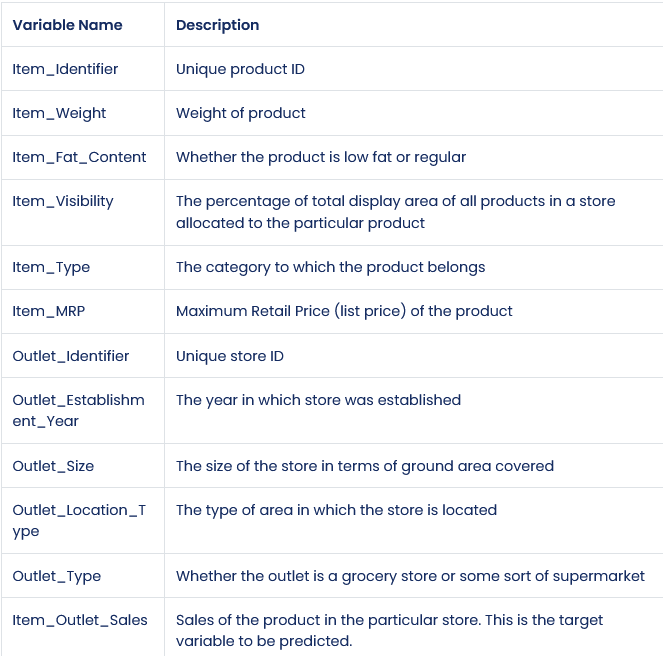

# Load and Inspect Data

In [308]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling & Preprocessing import
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor #Baseline model
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

## Regression Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn import set_config
set_config(transform_output='pandas')


In [309]:
import warnings
warnings.filterwarnings("ignore")

In [310]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [311]:
# Load Data
df = pd.read_csv('/content/drive/MyDrive/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv')

In [312]:
# Create copy of original data
df_ml = df.copy()

In [313]:
df_ml.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [314]:
# Use .info() to show rows and columns
df_ml.info()
# 8523 rows and 12 columns
# There are 5 Numerical datatypes(1-Int, 4-Floats)
# There are 7 categorical datatypes(7 Strings)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# Functions

Function to take the true predicted values and print MAE, MSE, RMSE, and R2 metrics for a model

In [315]:
def error_score(y_true, y_pred, name='model'):
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  print(f'{name} Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

# Clean Data

## Checking datatypes

In [316]:
# Display the descriptive statistics for the numerical columns
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


The numerical values look normal here. the max and min are showing any extreme values that aren't realistic. 

In [317]:
# Display the descriptive statistics for the categorical columns
df.describe(exclude="number")

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,5,16,10,3,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5089,1232,935,2793,3350,5577


## Remove Unnessary Columns

- The Item_Identifier column is showing high cardinality with its 1559 unique values when checking the descriptive stats.
- We will remove this column becasue with its high cardinality it could impact our learning model prediction performance.
- We will drop this column in our preprocessing phase.

## Checking for Duplicate Rows

In [318]:
# Checking for duplicate data
# Create a filter that identitfies duplicate rows
duplicated_rows = df.duplicated()

# Get sum of sum of duplicated rows filter
duplicated_rows.sum()
# We have 0 duplicate rows which is fantastic

0

## Inspect Values for Errors

In [319]:
# Check numerical values
df.describe(include='number')

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


The numerical values don't show extemely low or high numbers for max and min values and also the mean averages are 

In [320]:
# Make object variable
obj_cols = df.select_dtypes("object").columns
obj_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [321]:
for col in obj_cols:
  print(f'Value Counts for {col}')
  print(df[col].value_counts())
  print('\n')

Value Counts for Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Value Counts for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value Counts for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value Counts for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930


In [322]:
# Renaming 'reg' to 'Regular', 'LF' to 'Low Fat', and 'low fat' to 'Low Fat'

df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'reg':'Regular','LF':'Low Fat', 'low fat':'Low Fat' })

In [323]:
# Check to see if value names are changed 
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

## Checking Unique Values

In [324]:
df.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                2
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

## Identify Missing Values.

In [325]:
null_sum = df.isna().sum()
# print filter
null_sum

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [326]:
# Find % of null values for each column
null_percent = null_sum/len(df)*100
null_percent

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

# X and y test split


In [327]:
target = 'Item_Outlet_Sales'
y = df[target].copy()
X = df.drop(columns=target).copy()
X.head()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1


## Train-Test-Split

In [328]:
# Perfoming a train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## Drop Column with high cardinality

In [329]:
# Drop 'Item_Identifier' Column
X_train = X_train.drop(columns=['Item_Identifier'])
X_test  = X_test.drop(columns=['Item_Identifier'])
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,Low Fat,0.029565,Household,256.4646,OUT018,2009,Medium,Tier 3,Supermarket Type2
7510,15.250,Regular,0.000000,Snack Foods,179.7660,OUT018,2009,Medium,Tier 3,Supermarket Type2
5828,12.350,Regular,0.158716,Meat,157.2946,OUT049,1999,Medium,Tier 1,Supermarket Type1
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,OUT035,2004,Small,Tier 2,Supermarket Type1
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,OUT045,2002,NaN,Tier 2,Supermarket Type1


## Making a Preprocessing Pipeline

### Numeric

In [330]:
# PREPROCESSING PIPELINE FOR NUMERIC DATA

# Save list of number column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)

# Transformers
mean_imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Pipeline
num_pipeline = make_pipeline(mean_imputer, scaler)
num_pipeline

# Tuple
numeric_tuple = ('numeric',num_pipeline, num_cols)

Numeric Columns: Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')


### Ordinal 

In [331]:
df["Outlet_Establishment_Year"].value_counts()

1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

In [332]:
df["Outlet_Size"].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [333]:
# Creating a pipline for Ordinal data

# save list of number columns names
ord_cols =  ['Outlet_Size']

# Order category list
outlet_size_list = ['Small', 'Medium', 'High']
#outlet_year_list = ['1985','1987','1997','1998','1999','2002', '2004', '2007', '2009']

# Transformers
ord = OrdinalEncoder(categories=[outlet_size_list])
# Strategy for null values
freq_imputer = SimpleImputer(strategy='most_frequent')
# Scaler
scaler2 = StandardScaler()

# Pipeline
ord_pipeline= make_pipeline(freq_imputer, ord, scaler2)

# Tuple
ord_tuple = ('ordinal',ord_pipeline, ord_cols)

### Categorical

In [334]:
# PREPROCESSING PIPELINE FOR Categorical DATA

# Save list of nominal column names
# select all object columns and drop the ordinal colums we used above, so we are left with 'color' columns
cat_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns
print("Categorical Columns: ", cat_cols)

# Transformers

missing_imputer = SimpleImputer(strategy='constant', fill_value='missing')
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Pipeline
cat_pipeline = make_pipeline(missing_imputer , ohe)

# Tuple
cat_tuple = ('categorical',cat_pipeline, cat_cols)

Categorical Columns:  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')


# Create Preprocessor

In [335]:
preprocessor = ColumnTransformer([cat_tuple, numeric_tuple, ord_tuple],
                                 verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[(...
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size'])],
                  verbose_feature_names_out=False)

# Dummy Model

In [336]:
## Create an instance of the model
dummy = DummyRegressor(strategy='mean')

## Create a model pipeline
dummy_pipe = make_pipeline(preprocessor, dummy)

## Fit the model
dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='o...
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'High']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size'])],
                                   verbose_feature_names_out=False)),
                ('dummyregressor', DummyRegressor())])

## Dummy Metrics

In [337]:
## Display model performance metrics using a function
dy_train_preds = dummy_pipe.predict(X_train)
dy_test_preds = dummy_pipe.predict(X_test)

error_score(y_train, dy_train_preds, name='Dummy baseline Regression Train')
error_score(y_test, dy_test_preds, name='Dummy baseline Regression Test')

Dummy baseline Regression Train Scores
MAE: 1,360.2184 
MSE: 2,959,455.7045 
RMSE: 1,720.3069 
R2: 0.0000

Dummy baseline Regression Test Scores
MAE: 1,326.1210 
MSE: 2,772,144.4627 
RMSE: 1,664.9758 
R2: -0.0048



# **Linear Regression Model**
- Instantiate the model.
- Create a model pipeline using the preprocessor and model.
- Fit the model pipeline on the X_train dataset.

In [338]:
## Create an instance of the model
linreg = LinearRegression()

## Create a model pipeline
linreg_pipe = make_pipeline(preprocessor, linreg)

## Fit the model
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='o...
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'High']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size'])],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

## Evaluate model performance on both training set and the test set. Finding the R_squared score and RMSE score

In [339]:
# Save predictions for training and test data
y_train_preds = linreg_pipe.predict(X_train)
y_test_preds = linreg_pipe.predict(X_test)

error_score(y_train, y_train_preds, name='Linear Regression Train')
error_score(y_test, y_test_preds, name='Linear Regression Test')

Linear Regression Train Scores
MAE: 848.5546 
MSE: 1,302,366.3856 
RMSE: 1,141.2127 
R2: 0.5599

Linear Regression Test Scores
MAE: 801.7139 
MSE: 1,189,998.5842 
RMSE: 1,090.8706 
R2: 0.5687



# **Regression Tree Model**
- Instantiate the model.
- Create a model pipeline using the preprocessor and model.
- Fit the model pipeline on the X_train dataset.

In [340]:
## Create an instance of the model
dec_tree = DecisionTreeRegressor(random_state = 42)

## Create a model pipeline
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)

## Fit the model
dec_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='o...
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'High']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size'])],
                                   verbose_feature_names_out=False)),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

## Evaluate model performance on both training set and the test set. Finding the R_squared score and RMSE score

In [341]:
# Save predictions for training and test data
train_preds = dec_tree_pipe.predict(X_train)
test_preds = dec_tree_pipe.predict(X_test)

error_score(y_train, train_preds, name='Decision Tree Regression Train')
error_score(y_test, test_preds, name='Decision Tree Regression Test')

Decision Tree Regression Train Scores
MAE: 0.0000 
MSE: 0.0000 
RMSE: 0.0000 
R2: 1.0000

Decision Tree Regression Test Scores
MAE: 1,044.0613 
MSE: 2,257,789.3906 
RMSE: 1,502.5942 
R2: 0.1817



## Tune Model

Since the model has a much higher r2 score on the training than test data, its shows this model is overfitted and has very high varience.

In [342]:
# Display hyperparameters for tuning
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [343]:
# Display the model depth default
dec_tree.get_depth()

40

In [344]:
# Display model depth default # of leaves
dec_tree.get_n_leaves()

6271

In [345]:
# List of values to try for max_depth:
max_depth_range = list(range(2, 20)) # will try every value between 2 and 20
# List to store the score for each value of max_depth:
train_r2 = []
test_r2 = []
for depth in max_depth_range:
    dec_tree = DecisionTreeRegressor(max_depth = depth, 
                             random_state = 42)
    dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
    dec_tree_pipe.fit(X_train, y_train)
    train_score = dec_tree_pipe.score(X_train, y_train)
    test_score = dec_tree_pipe.score(X_test, y_test)
    train_r2.append(train_score)
    test_r2.append(test_score)

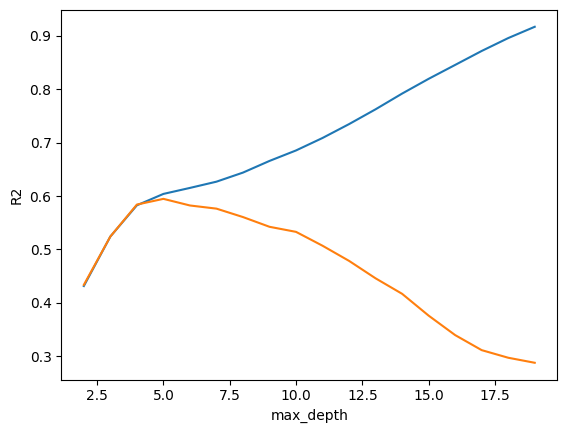

In [346]:
# Plot the r2 train and test score over different depths
plt.plot(max_depth_range, train_r2)
plt.plot(max_depth_range, test_r2)
plt.xlabel('max_depth')
plt.ylabel('R2');

- Here we can see the r2 score of the train and test data between each depth
- Orange line shows the test r2 and the blue line shows the train r2
- It looks like at 5 r2 has the highest r2 score from all depths tested

In [347]:
# Create an instance of the model
dec_tree5 = DecisionTreeRegressor(max_depth=5, random_state = 42)
# Create a model pipeline
dec_tree5_pipe = make_pipeline(preprocessor, dec_tree5)
# Fit the model
dec_tree5_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='o...
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'High']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size'])],
                                   verbose_feature_names_out=False)),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=5, random_state=42))])

In [348]:
# Display model performance metrics
train_preds5 = dec_tree5_pipe.predict(X_train)
test_preds5 = dec_tree5_pipe.predict(X_test)

error_score(y_train, train_preds5, name='Decision Tree Depth 5')
error_score(y_test, test_preds5, name='Decision Tree Depth 5')

Decision Tree Depth 5 Scores
MAE: 762.6102 
MSE: 1,172,122.7729 
RMSE: 1,082.6462 
R2: 0.6039

Decision Tree Depth 5 Scores
MAE: 738.3173 
MSE: 1,118,185.9731 
RMSE: 1,057.4431 
R2: 0.5947



# Bagged Tree model

In [349]:
# Create an instance of the model
bag_tree = BaggingRegressor(random_state = 42)

# Create a model pipeline
bag_tree_pipe = make_pipeline(preprocessor, bag_tree)

# Fit the model
bag_tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='o...
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'High']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size'])],
                                   verbose_feature_names_out=False)),
                ('baggingregressor', BaggingRegressor(random_state=42))])

## Bagged Tree Metrics

In [350]:
train_preds = bag_tree_pipe.predict(X_train)
test_preds = bag_tree_pipe.predict(X_test)

error_score(y_train, train_preds, name='Bagged Tree Train')
error_score(y_test, test_preds, name='Bagged Tree Test')

Bagged Tree Train Scores
MAE: 319.9601 
MSE: 240,827.1052 
RMSE: 490.7414 
R2: 0.9186

Bagged Tree Test Scores
MAE: 775.3962 
MSE: 1,269,182.9319 
RMSE: 1,126.5802 
R2: 0.5400



## Tune Model

In [351]:
# Look at the hyperparameters
bag_tree.get_params()

{'base_estimator': 'deprecated',
 'bootstrap': True,
 'bootstrap_features': False,
 'estimator': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### Tune n_estimators

In [352]:
# List of estimator values
estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# Data frame to store the scores
scores = pd.DataFrame(index=estimators, columns=['Train Score', 'Test Score'])
# Iterate through the values to find the best number of estimators
for num_estimators in estimators:
  bagtree = BaggingRegressor(n_estimators=num_estimators, random_state=42)
  # Create a model pipeline
  bagtree_pipe = make_pipeline(preprocessor, bagtree)
  # Fit the model
  bagtree_pipe.fit(X_train, y_train)
  # Metrics
  train_preds = bagtree_pipe.predict(X_train)
  test_preds = bagtree_pipe.predict(X_test)
  bagrtree_train_score = r2_score(y_train, train_preds)
  bagtree_test_score = r2_score(y_test, test_preds)
  # Store r2 score for graph
  scores.loc[num_estimators, 'Train Score'] = bagrtree_train_score
  scores.loc[num_estimators, 'Test Score'] = bagtree_test_score

  # Print Results
  print(f'When estimator is {num_estimators}:')
  error_score(y_train, train_preds, name='Bagged Tree Train Tuned')
  error_score(y_test, test_preds, name='Bagged Tree Test Tuned')
 

When estimator is 10:
Bagged Tree Train Tuned Scores
MAE: 319.9601 
MSE: 240,827.1052 
RMSE: 490.7414 
R2: 0.9186

Bagged Tree Test Tuned Scores
MAE: 775.3962 
MSE: 1,269,182.9319 
RMSE: 1,126.5802 
R2: 0.5400

When estimator is 20:
Bagged Tree Train Tuned Scores
MAE: 309.1857 
MSE: 214,104.0785 
RMSE: 462.7138 
R2: 0.9277

Bagged Tree Test Tuned Scores
MAE: 776.3777 
MSE: 1,259,934.7855 
RMSE: 1,122.4682 
R2: 0.5433

When estimator is 30:
Bagged Tree Train Tuned Scores
MAE: 303.5338 
MSE: 201,605.5030 
RMSE: 449.0050 
R2: 0.9319

Bagged Tree Test Tuned Scores
MAE: 772.1100 
MSE: 1,241,721.8449 
RMSE: 1,114.3257 
R2: 0.5499

When estimator is 40:
Bagged Tree Train Tuned Scores
MAE: 301.8389 
MSE: 196,573.8087 
RMSE: 443.3664 
R2: 0.9336

Bagged Tree Test Tuned Scores
MAE: 769.5780 
MSE: 1,232,473.9423 
RMSE: 1,110.1684 
R2: 0.5533

When estimator is 50:
Bagged Tree Train Tuned Scores
MAE: 299.3199 
MSE: 191,124.9168 
RMSE: 437.1784 
R2: 0.9354

Bagged Tree Test Tuned Scores
MAE: 767.89

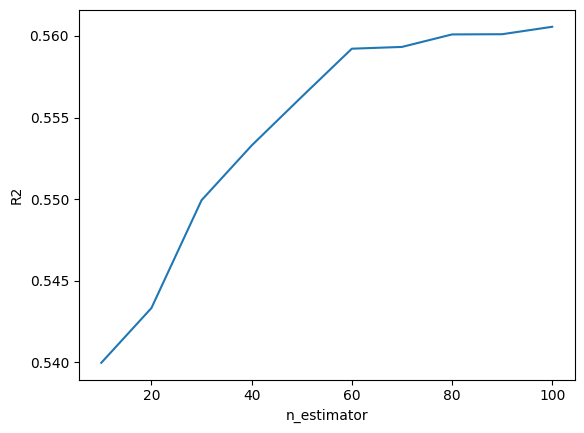

In [353]:
# Plot the scores
plt.plot(scores['Test Score'])
plt.xlabel('n_estimator')
plt.ylabel('R2');
plt.show()


In [354]:
# Sort by test score
bagr2_scores = scores.sort_values(by='Test Score', ascending=False)
bagr2_scores

,Train Score,Test Score
100,0.938235,0.560558
90,0.937951,0.560103
80,0.937631,0.56009
70,0.937089,0.559324
60,0.936332,0.559215
50,0.935419,0.55627
40,0.933578,0.553286
30,0.931878,0.549934
20,0.927654,0.543333
10,0.918625,0.539981


In [355]:
# Save the index value of the best test score.
best_n_estimators = scores.index[0]
# Instantiate and fit the best version of the model
bagtree_tuned = BaggingRegressor(n_estimators=best_n_estimators,random_state=42)
bagtree_tuned_pipe = make_pipeline(preprocessor, bagtree)
bagtree_tuned_pipe.fit(X_train, y_train)
# Evaluate the model
train_preds = bagtree_tuned_pipe.predict(X_train)
test_preds = bagtree_tuned_pipe.predict(X_test)
error_score(y_train, train_preds, name='Bagged Tree Train Tuned')
error_score(y_test, test_preds, name='Bagged Tree Test Tuned')


Bagged Tree Train Tuned Scores
MAE: 296.5080 
MSE: 182,791.4577 
RMSE: 427.5412 
R2: 0.9382

Bagged Tree Test Tuned Scores
MAE: 765.5779 
MSE: 1,212,411.1525 
RMSE: 1,101.0954 
R2: 0.5606



# Random Forest Model

In [356]:
## Create an instance of the model
ran_for = RandomForestRegressor(random_state = 42)

## Create a model pipeline
ran_for_pipe = make_pipeline(preprocessor, ran_for)

## Fit the model
ran_for_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='o...
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'High']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size'])],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

## Random Forest Metrics

In [357]:
## Display model performance metrics using a function
train_preds = ran_for_pipe.predict(X_train)
test_preds = ran_for_pipe.predict(X_test)

error_score(y_train, train_preds, name='Random Forest Train')
error_score(y_test, test_preds, name='Random Forest Test')

Random Forest Train Scores
MAE: 296.3903 
MSE: 182,806.1702 
RMSE: 427.5584 
R2: 0.9382

Random Forest Test Scores
MAE: 765.8869 
MSE: 1,215,112.2621 
RMSE: 1,102.3213 
R2: 0.5596



## Tune Model

In [358]:
# Looking at some hyperparameters that seem tunable
ran_for.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### Tuning max_depth

In [359]:
# Get the depths of each tree in the random forest
est_depths = [estimator.get_depth() for estimator in ran_for.estimators_]
# Get the maximum depth
max(est_depths)

42

In [364]:
# Make list of depths to try
depths = range(1, max(est_depths))

# Make dataframe for results
scores2 = pd.DataFrame(index=depths, columns=['Test Score'])

# Try the different values for depths
for depth in depths:    
   rft = RandomForestRegressor(random_state = 42, max_depth=depth)
   # Create pipeline
   rft_pipe = make_pipeline(preprocessor, rft)
   # Fit the model on training data
   rft_pipe.fit(X_train, y_train)
   # Make predictions on training and test data
   train_preds = rft_pipe.predict(X_train)
   test_preds = rft_pipe.predict(X_test)
   # Obtain scores and add to dataframe
   scores2.loc[depth, 'Train Score'] = r2_score(y_train, train_preds)
   scores2.loc[depth, 'Test Score'] = r2_score(y_test, test_preds)

# View first 5 rows of score dataframe
scores2.head()

,Test Score,Train Score
1,0.243857,0.253582
2,0.465954,0.462651
3,0.545216,0.544065
4,0.596631,0.595925
5,0.602609,0.610540


In [366]:
# Sort by the best score on testing data
sorted_scores = scores2.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
5,0.602609,0.610540
6,0.601261,0.624540
7,0.59856,0.643132
8,0.596925,0.666373
4,0.596631,0.595925


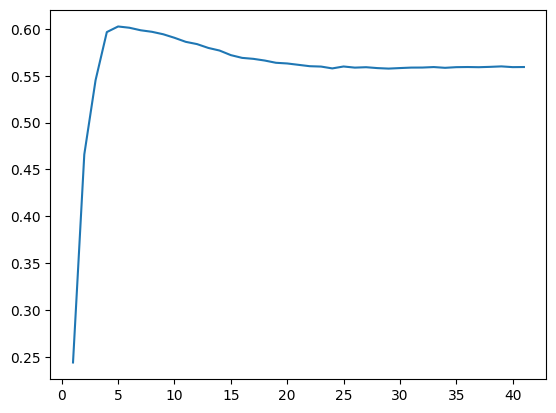

In [368]:
# Plot the scores
plt.plot(scores2['Test Score'])

### Tuning n_esitmator 

In [377]:
# Choose values for n_estimators to try
n_ests = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550]

# Create a dataframe for the results
scores3 = pd.DataFrame(index=n_ests, columns=['Test Score', 'Train Score'])

# Test the different values for n_estimators
for n in n_ests:
  rft2 = RandomForestRegressor(random_state = 42, max_depth=29, n_estimators=n)
  # Create pipeline
  rft2_pipe = make_pipeline(preprocessor, rft2)
  # Fit the model on training data
  rft2_pipe.fit(X_train, y_train)

  # Make predictions on  training and testing data
  train_preds = rft2_pipe.predict(X_train)
  test_preds = rft2_pipe.predict(X_test)

  # Obtain scores and add to scores df
  scores2.loc[n, 'Train Score'] = r2_score(y_train, train_preds)
  scores2.loc[n, 'Test Score'] = r2_score(y_test, test_preds)

# View first 5 results of score dataframe
  scores3.head()

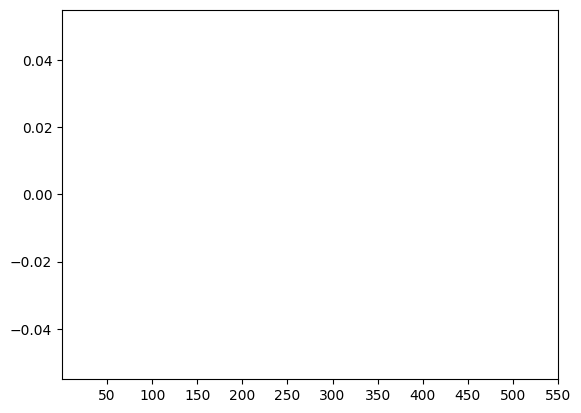

In [376]:
plt.plot(scores3['Test Score'])
plt.xticks(n_ests);

In [378]:
sorted_scores3 = scores3.sort_values(by='Test Score', ascending=False)
sorted_scores3.head()

,Test Score,Train Score
50,NaN,NaN
100,NaN,NaN
150,NaN,NaN
200,NaN,NaN
250,NaN,NaN


# Which model is the best?

- Focusing on the untuned Linear regression and the regression tree models. The model with the best fit would be our decsison Tree model, I say this becasue it has the highest r2 score at 0.5947.

- This model did slightly better than our linear regression model and since the train and test r2 are close in size this model shows the least overfitment.

- The other models beside linear regression show extreme variance and overfitting with the training r2 scores being higher than the testing.

